In [1]:
import os
import random
import hashlib
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MFCC, MelSpectrogram, AmplitudeToDB

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


SAMPLE_RATE = 16000
SAMPLE_LENGTH = SAMPLE_RATE
NUM_MFCC = 13

class KWSDataset(Dataset):
    def __init__(self, data_dir, mode="training",
                 wanted_words=None,
                 background_frequency=0.8,
                 background_volume=0.1,
                 silence_percentage=10.0,
                 unknown_percentage=10.0,
                 time_shift_ms=100.0,
                 use_mfcc=True):
        self.data = []
        self.labels = []
        self.mode = mode
        self.use_mfcc = use_mfcc
        self.background_frequency = background_frequency
        self.background_volume = background_volume
        self.silence_percentage = silence_percentage
        self.unknown_percentage = unknown_percentage
        self.time_shift_samples = int(SAMPLE_RATE * time_shift_ms / 1000)

        self.wanted_words = wanted_words.split(',')
        self.label_map = {word: i for i, word in enumerate(self.wanted_words + ['silence', 'unknown'])}

        self.background_noises = self.load_background_noises(os.path.join(data_dir, '_background_noise_'))
        self.word_to_files = self.index_audio_files(data_dir)

        self.prepare_dataset()
        self.mfcc_transform = MFCC(sample_rate=SAMPLE_RATE, n_mfcc=NUM_MFCC) if use_mfcc else None

    def load_background_noises(self, noise_dir):
        return [torchaudio.load(os.path.join(noise_dir, f))[0].squeeze(0)
                for f in os.listdir(noise_dir) if f.endswith(".wav")]

    def index_audio_files(self, data_dir):
        word_to_files = {}
        for word in os.listdir(data_dir):
            full_path = os.path.join(data_dir, word)
            if not os.path.isdir(full_path) or word.startswith("_"):
                continue
            word_to_files[word] = [os.path.join(full_path, f)
                                   for f in os.listdir(full_path) if f.endswith(".wav")]
        return word_to_files

    def which_set(self, filename):
        base_name = os.path.basename(filename)
        hash_name = base_name.split("_nohash_")[0]
        hash_val = int(hashlib.sha1(hash_name.encode("utf-8")).hexdigest(), 16)
        percentage = (hash_val % (2**27)) * (100.0 / (2**27))
        if percentage < 10:
            return 'validation'
        elif percentage < 20:
            return 'testing'
        else:
            return 'training'

    def prepare_dataset(self):
        all_files = []
        for word, files in self.word_to_files.items():
            for f in files:
                if self.which_set(f) == self.mode:
                    all_files.append((word, f))

        # Filter files
        keyword_files = [(w, f) for w, f in all_files if w in self.wanted_words]
        unknown_files = [(w, f) for w, f in all_files if w not in self.wanted_words]

        n_total = len(keyword_files)
        n_silence = int(n_total * self.silence_percentage / 100)
        n_unknown = int(n_total * self.unknown_percentage / 100)

        self.samples = []

        self.samples += [(f, self.label_map[w]) for w, f in keyword_files]
        self.samples += [(f, self.label_map['unknown']) for w, f in random.sample(unknown_files, min(n_unknown, len(unknown_files)))]
        self.samples += [('silence', self.label_map['silence'])] * n_silence

        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def time_shift(self, waveform):
        shift = random.randint(-self.time_shift_samples, self.time_shift_samples)
        return torch.roll(waveform, shifts=shift)

    def add_background(self, waveform):
        if self.background_noises and random.random() < self.background_frequency:
            noise = random.choice(self.background_noises)
            if noise.size(0) < SAMPLE_LENGTH:
                noise = torch.nn.functional.pad(noise, (0, SAMPLE_LENGTH - noise.size(0)))
            start = random.randint(0, noise.size(0) - SAMPLE_LENGTH)
            noise_segment = noise[start:start + SAMPLE_LENGTH]
            waveform = waveform + self.background_volume * noise_segment
        return waveform

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        if path == 'silence':
            waveform = torch.zeros(SAMPLE_LENGTH)
        else:
            waveform, sr = torchaudio.load(path)
            waveform = waveform.mean(0)
            if sr != SAMPLE_RATE:
                waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)
            waveform = waveform[:SAMPLE_LENGTH]
            if waveform.size(0) < SAMPLE_LENGTH:
                waveform = torch.nn.functional.pad(waveform, (0, SAMPLE_LENGTH - waveform.size(0)))
            waveform = self.time_shift(waveform)
            waveform = self.add_background(waveform)

        if self.use_mfcc:
            features = self.mfcc_transform(waveform)
        else:
            features = AmplitudeToDB()(MelSpectrogram(sample_rate=SAMPLE_RATE)(waveform))

        return features, label


In [5]:

class MicroLMUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, memory_size, memory_tapes, dropout=0.0):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.memory_size = memory_size
        self.memory_tapes = memory_tapes
        self.memory_total = memory_tapes * memory_size
        self.dropout = dropout

        self.xh = nn.Linear(input_dim, hidden_dim, bias=False)
        self.bh = nn.Parameter(torch.zeros(hidden_dim))
        self.mh = nn.Linear(self.memory_total, hidden_dim, bias=False)
        self.xe = nn.Linear(input_dim, memory_tapes, bias=False)
        self.he = nn.Linear(hidden_dim, memory_tapes, bias=False)

        self.theta_inv = nn.Parameter(torch.rand(memory_tapes) * (1 / (4 * memory_size)))

        Q = torch.arange(memory_size).float()
        R = (2 * Q + 1).view(-1, 1)
        j, i = torch.meshgrid(Q, Q, indexing="ij")

        A = torch.where(i < j, -1.0, (-1.0)**(i - j + 1)) * R
        B = ((-1.0)**Q * R.squeeze()).view(-1)
        self.register_buffer('A', A)
        self.register_buffer('B', B)

    def forward(self, x, state):
        h, m = state
        batch_size = x.size(0)
        m = m.view(batch_size, self.memory_tapes, self.memory_size)

        u = self.xe(x) + self.he(h)
        A, B = self.A, self.B
        theta_inv = torch.clamp(self.theta_inv, min=1e-5)

        m_new = []
        for t in range(self.memory_tapes):
            m_t = m[:, t, :]
            Bu_t = u[:, t].unsqueeze(1) * B.unsqueeze(0)
            update = F.linear(m_t, A) + Bu_t
            m_t = m_t + theta_inv[t] * update
            m_new.append(m_t)

        m = torch.stack(m_new, dim=1)
        m_flat = m.view(batch_size, -1)

        h_next = F.relu(self.xh(x) + self.mh(m_flat) + self.bh)

        if self.dropout > 0.0 and self.training:
            h_next = F.dropout(h_next, p=self.dropout)

        return h_next, (h_next, m_flat)

class StackedMicroLMU(nn.Module):
    def __init__(self, input_dim, hidden_dim, memory_size, memory_tapes, num_layers, dropout):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(
                MicroLMUCell(
                    input_dim if i == 0 else hidden_dim,
                    hidden_dim,
                    memory_size,
                    memory_tapes,
                    dropout
                )
            )
        self.hidden_dim = hidden_dim
        self.memory_total = memory_tapes * memory_size
        self.num_layers = num_layers

    def forward(self, x):
        batch_size, time_steps, input_dim = x.shape
        h = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        m = torch.zeros(batch_size, self.memory_total, device=x.device)

        for t in range(time_steps):
            h_in = x[:, t, :]
            for i in range(self.num_layers):
                h, (h, m) = self.layers[i](h_in, (h, m))
                h_in = h

        return h

class LMUModel(nn.Module):
    def __init__(self, input_dim, label_count,
                 hidden_size=312, memory_size=4, memory_tapes=22,
                 num_layers=3, dropout=0.1, final_units=[128, 256], final_acts=['linear', 'relu']):
        super().__init__()
        self.lmu_stack = StackedMicroLMU(input_dim, hidden_size, memory_size, memory_tapes, num_layers, dropout)

        layers = []
        in_dim = hidden_size
        for units, act in zip(final_units, final_acts):
            layers.append(nn.Linear(in_dim, units))
            if act == 'relu':
                layers.append(nn.ReLU())
            elif act == 'linear':
                pass
            else:
                raise ValueError(f"Unsupported activation: {act}")
            in_dim = units

        layers.append(nn.Linear(in_dim, label_count))
        self.head = nn.Sequential(*layers)

    def forward(self, x):
        # x: (batch, input_dim, time_steps) → (batch, time_steps, input_dim)
        x = x.transpose(1, 2)
        x = self.lmu_stack(x)
        return self.head(x)

# Instantiate model and test on dummy input
model = LMUModel(input_dim=sample_data.shape[1], label_count=12)
dummy_input = torch.randn(32, 13, 81)  # (batch, mfcc_dim, time)
output = model(dummy_input)
print("Output shape:", output.shape)  # Should be (batch, 12) for 12 class logits


NameError: name 'sample_data' is not defined

In [52]:
wanted_words = "yes,no,up,down,left,right,on,off,stop,go"
background_frequency=0.8
background_volume=0.1
silence_percentage=10.0
unknown_percentage=10.0
time_shift_ms=100.0
use_mfcc=True

# Load datasets
train_dataset = KWSDataset(
    data_dir="./speech_commands_v1",
    mode="training",
    wanted_words=wanted_words,
    background_frequency=background_frequency,
    background_volume=background_volume,
    silence_percentage=silence_percentage,
    unknown_percentage=unknown_percentage,
    time_shift_ms=time_shift_ms,
    use_mfcc=use_mfcc
)
val_dataset = KWSDataset(
    data_dir="./speech_commands_v1",
    mode="validation",
    wanted_words=wanted_words,
    background_frequency=background_frequency,
    background_volume=background_volume,
    silence_percentage=silence_percentage,
    unknown_percentage=unknown_percentage,
    time_shift_ms=time_shift_ms,
    use_mfcc=use_mfcc
)



/home/vdhanraj/anaconda3/envs/torch/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
# Training config
BATCH_SIZE = 128
NUM_CLASSES = 12
EPOCHS = 15
LEARNING_RATE = 0.0005
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

sample_input, sample_output = next(iter(train_loader))
input_dim = sample_input.shape[1]  # MFCC channels
time_steps = sample_input.shape[2]  # Time steps

# Model
model = LMUModel(input_dim=input_dim, label_count=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

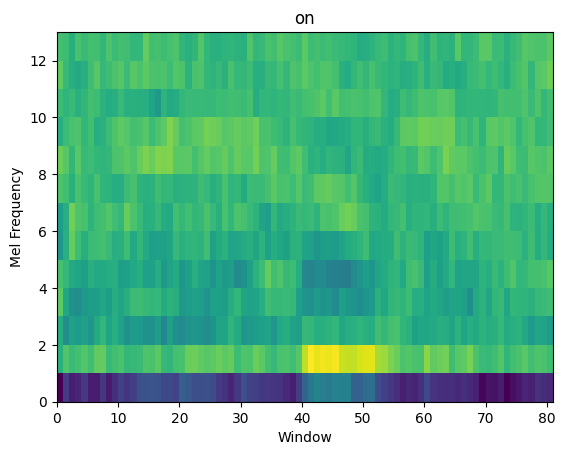

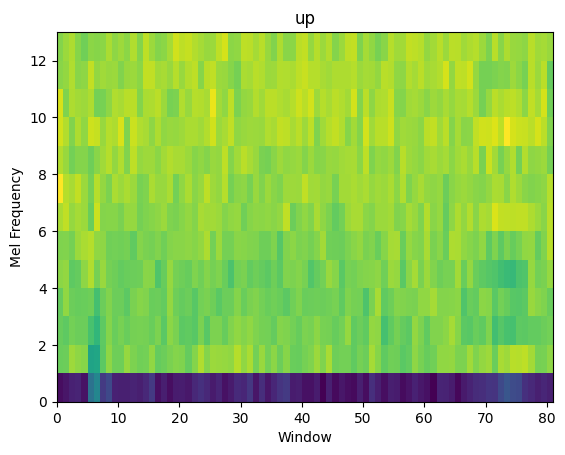

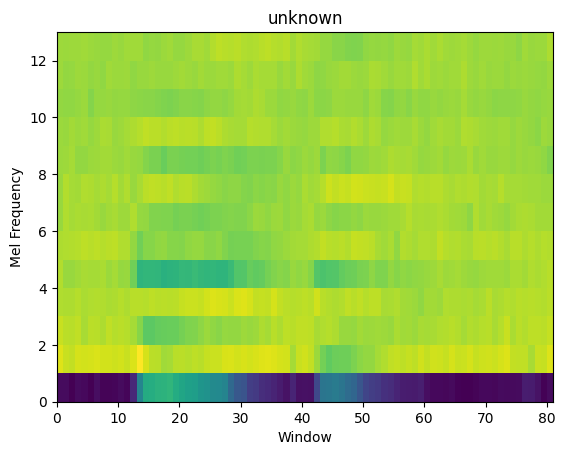

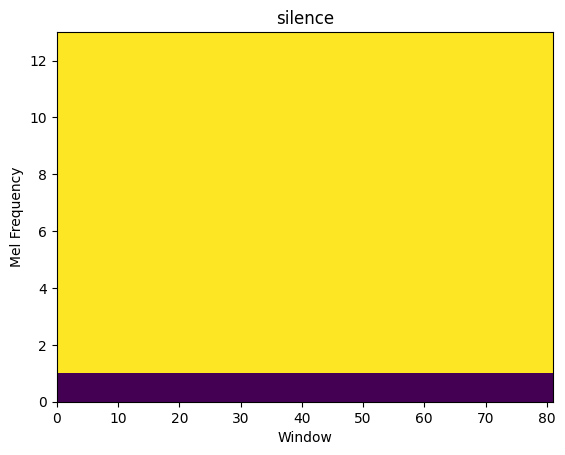

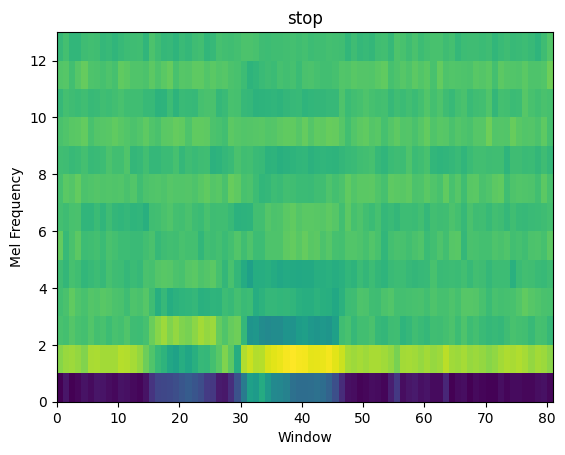

In [58]:
label_list = wanted_words.split(",") + ["silence", "unknown"]
for b in range(5): # Plot the first 5 input data spectrograms
    plt.pcolormesh(sample_input[b])
    plt.title(label_list[sample_output[b]])
    plt.xlabel("Window")
    plt.ylabel("Mel Frequency" if use_mfcc else "Frequency")
    plt.show()

In [43]:

# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1} | Loss: {total_loss / len(train_loader):.4f} | Train Acc: {train_acc:.2f}%")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    val_acc = 100. * correct / total
    print(f"Validation Acc: {val_acc:.2f}%")


Epoch 1 | Loss: 2.3555 | Train Acc: 14.75%
           Validation Acc: 16.79%
Epoch 2 | Loss: 2.1228 | Train Acc: 21.47%
           Validation Acc: 28.66%
Epoch 3 | Loss: 1.7382 | Train Acc: 36.72%
           Validation Acc: 42.90%
Epoch 4 | Loss: 1.3280 | Train Acc: 52.58%
           Validation Acc: 58.10%
Epoch 5 | Loss: 1.0548 | Train Acc: 63.33%
           Validation Acc: 65.84%
Epoch 6 | Loss: 0.9041 | Train Acc: 68.80%
           Validation Acc: 71.34%
Epoch 7 | Loss: 0.7942 | Train Acc: 72.69%
           Validation Acc: 74.47%
Epoch 8 | Loss: 0.7299 | Train Acc: 74.92%
           Validation Acc: 76.97%
Epoch 9 | Loss: 0.6564 | Train Acc: 77.73%
           Validation Acc: 77.90%
Epoch 10 | Loss: 0.6192 | Train Acc: 79.20%
           Validation Acc: 80.69%
Epoch 11 | Loss: 0.5701 | Train Acc: 80.84%
           Validation Acc: 79.00%
Epoch 12 | Loss: 0.5510 | Train Acc: 81.59%
           Validation Acc: 81.69%
Epoch 13 | Loss: 0.5223 | Train Acc: 82.56%
           Validation Acc: 83